In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.optimize import minimize,curve_fit

# Magic command Needed for showing plots in jupyter notebooks
%matplotlib inline

In [8]:
# Adjust plot dpi and other graphical parameters
plt.rcParams.update(**{
    'figure.dpi':150,
    'figure.figsize':(4,3)
})

# 1. Linear regression on autompg dataset

The `autompg` dataset concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes. There are 398 instances.

**Attribute information**:

    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)
    
There are 6 missing entries for `horsepower`, indicated in the file as  `?`. 

In the following code block,

1. The data is loaded from disk.
2. Rows with missing data are dropped
3. Redundant columns are deleted
4. The output is extracted into variable `y`
5. The predictors are extracted into variable `X` and standardized.

In [2]:
# read autompg data - replace filedir with the actual location
FILEDIR = '../data'
auto = pd.read_csv(
    os.path.join(FILEDIR,'auto-mpg.csv'),
    na_values = '?' # needed to mark these entries as missing
)

# drop missing values
# axis = 0 - drop 
auto = auto.dropna(axis=0)

# car name is unique for each instance
# deleting the column
del auto['car name']


# preparing data for linear regression
# extract output
y = auto['mpg']

# standardizing columns in order to directly compare coefficients
X = auto.drop('mpg',axis=1)
X_mean,X_std = X.mean(axis=0),X.std(axis=0)
X = (X-X_mean)/X_std

(a) Fit a linear regression model for predicting mileage (`mpg`) as a function of the other variables. Use the `sm.OLS` class (with arguments `y` and `X`) from the statsmodels library. Print the summary of the model.

(b) Plot the residuals vs the fitted values. Do you notice anything? The residuals can be extracted through the `.resid` attribute of the `OLS` object.

**Note**: `OLS` fits a model without the intercept term. 

In [3]:
# add constant column to dependent variables
# need to calculate the intercept term
X = sm.add_constant(X,prepend=True)

# fit the linear model
fit_lm = sm.OLS(y,X).fit()
print(fit_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Tue, 10 Jan 2023   Prob (F-statistic):          2.04e-139
Time:                        17:54:19   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           23.4459      0.168    139.498   

/Users/surajys/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2629: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


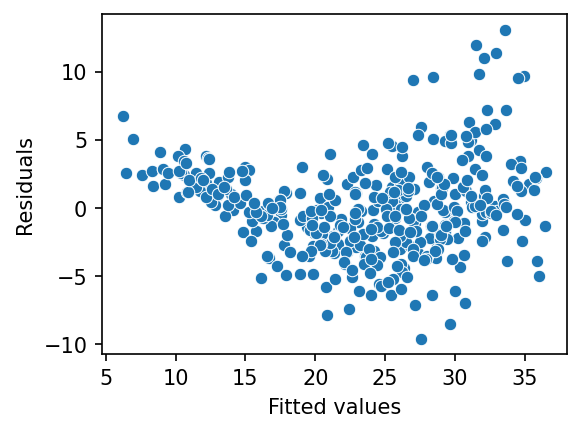

In [9]:
fig,ax = plt.subplots(1,1)
_ = sns.scatterplot(x=fit_lm.fittedvalues,y=fit_lm.resid,ax=ax)
_ = ax.set_xlabel('Fitted values')
_ = ax.set_ylabel('Residuals')

From the residual-vs-fitted plot, we can see that there is some non-linear effect not being captured by the linear model.

# 2. Non-linear regression


Consider the following generated data:

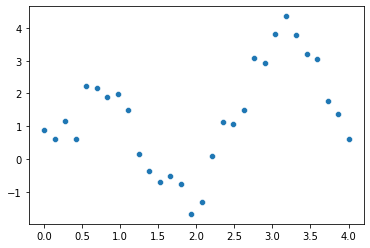

In [5]:
np.random.seed(11)
x = np.linspace(0,4,30)
y = 0.5*x + 2*np.sin(2.5*x) + 0.5*np.random.randn(x.shape[0])

fig,ax = plt.subplots(1,1)
_ = sns.scatterplot(x=x,y=y,ax=ax)

Fit the following model to this data:

$$
\widehat{y}\left(x,\theta \right) = \theta_0 + \theta_1 x  + \theta_3 \sin \left(\theta_2 x\right)
$$

using (a) general non-linear minimization (b) least squares algorithm. For each case, print the final values of the parameters.

Start from the initial guess $\boldsymbol{\theta} = [1,0.3,2,1.5]$.

In [6]:
def sine_model(x,theta):
    return theta[0] + theta[1]*x + theta[3]*np.sin(theta[2]*x)

def sse_model(theta,x,y):
    y_hat = sine_model(x,theta)
    return np.sum((y-y_hat)**2)

res_sine_nlm = minimize(
    fun = sse_model,
    x0 = [1,0.3,2,1.5],
    args=(x,y),
    options = {'disp':True}
)

print('Parameters estimated via NLM:')
print(res_sine_nlm.x)

Optimization terminated successfully.
         Current function value: 6.076154
         Iterations: 10
         Function evaluations: 78
         Gradient evaluations: 13
Parameters estimated via NLM:
[-0.20958212  0.60274236  2.52467224  2.05967246]


In [7]:
def sine_model_nls(x,*theta):
    return sine_model(x,theta)

theta_nls,cov_theta_nls = curve_fit(
    f = sine_model_nls, # the model to be fit to data 
    xdata = x,
    ydata = y,
    p0 = [1,0.3,2,1.5] # initial guess
)

print('Parameters estimated via NLS:')
print(theta_nls)

Parameters estimated via NLS:
[-0.20958311  0.60274318  2.5246731   2.05967232]
